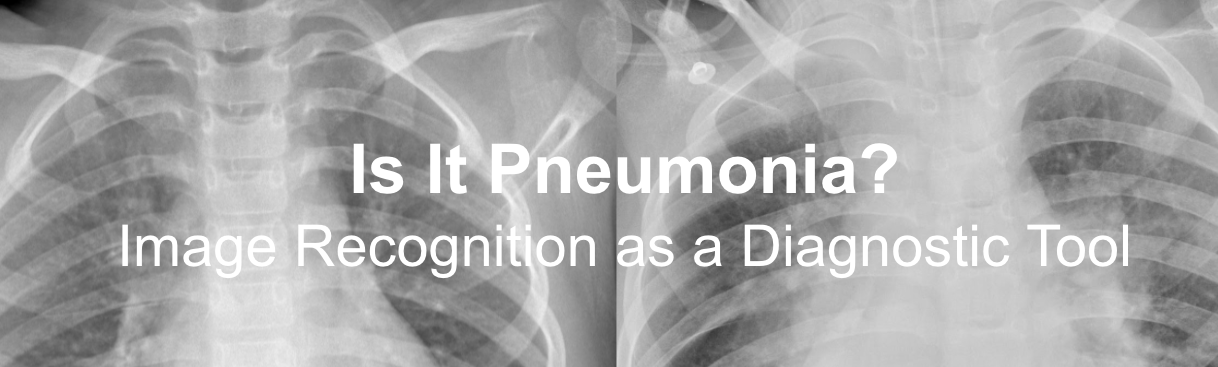

### Authors: [Richard Hinds](https://github.com/RH3421), [Nick Kennedy](https://github.com/nikennedy), and [Ilene Sorto](https://github.com/ileneee)

## Background
Globally, 1 in 71 children contract pneumonia every year. Unfortunately, pediatric pneumonia is also frequently fatal resulting in an estimated 2,200 deaths per day worldwide. To diagnose pediatric pneumonia, highly skilled physicians such as pediatric radiologists are needed to interpret the medical imaging. However, the distribution of these providers is highly disparate globally.

## Business Problem
Countries with few pediatric radiologists per capita may have potentially higher risks of delays in diagnosis and corresponding treatment failures. Higher costs and interventional risks may also be worsened. Thus, our team endeavored to produce a diagnostic support tool, leveraging machine learning to speed and improve diagnosis of pediatric pneumonia. We believe our diagnostic support tool will be particularly useful in helping healthcare providers in countries with few pediatric radiologists per capita.

## Data Understanding
We used 5224 pediatric chest xrays to develop a diagnostic support tool that can differentiate between a normal chest xray (CXR) and a chest xray in a pediatric patient with pneumonia. There were 1341 normal CXR, 3883 pneumonia CXR. Recall was the metric of choice as failure to properly diagnose pneumonia (or false negative) could potentially be fatal to the child. Using recall allows us to try to reduce these false negatives.

## Modeling
We used a convolutional neural network (CNN) to developed our diagnostic support tool as they’re good for image classification. CNNs are particularly strong when for image classification especially wehn geared towards color images.

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model
from keras.metrics import Recall
from keras.optimizers import Adam

In [2]:
# Instantiating ImageDataGenerator and normalizing the RGB values
traingen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
testgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
valgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# Creating training data generator
train_data = traingen.flow_from_directory(
    # Specifying location of training data
    directory='data_split/train',
    # Re-sizing images to 100x100
    target_size=(100, 100),
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=15,
    seed=16
)
# Creating testing data generator
test_data = testgen.flow_from_directory(
    # Specifying location of testing data
    directory='data_split/test',
    # Re-sizing images to 100x100
    target_size=(100, 100),
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=15,
    seed=16
)

# Creating validation set
val_data = valgen.flow_from_directory(
    # Specifying location of testing data
    directory='data_split/val',
    # Re-sizing images to 100x100
    target_size=(100, 100),
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=15,
    seed=16
)

Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Create classification for images.

In [3]:
# Putting image classification into a dataframe
classes = pd.DataFrame(train_data.classes)
values = classes.value_counts()

In [4]:
# Review classes
classes

,0
0,0
1,0
2,0
3,0
4,0
...,...
5219,1
5220,1
5221,1
5222,1


In [5]:
# Giving the data binary labels to allow for visialization of class imbalance below.
class_dict = {0:'Normal', 1:'PNA'}
classes[0] = classes[0].map(class_dict)

In [6]:
# Image counting
image_interpretation = classes[0].value_counts()
image_interpretation

PNA       3883
Normal    1341
Name: 0, dtype: int64

In [7]:
# Percent of PNA vs normal chest xrays
classes[0].value_counts(normalize=True)

PNA       0.7433
Normal    0.2567
Name: 0, dtype: float64

In [8]:
image_interpretation.index

Index(['PNA', 'Normal'], dtype='object')

Now that we have our train data and classification, let's visualize the images for preliminary inspection.

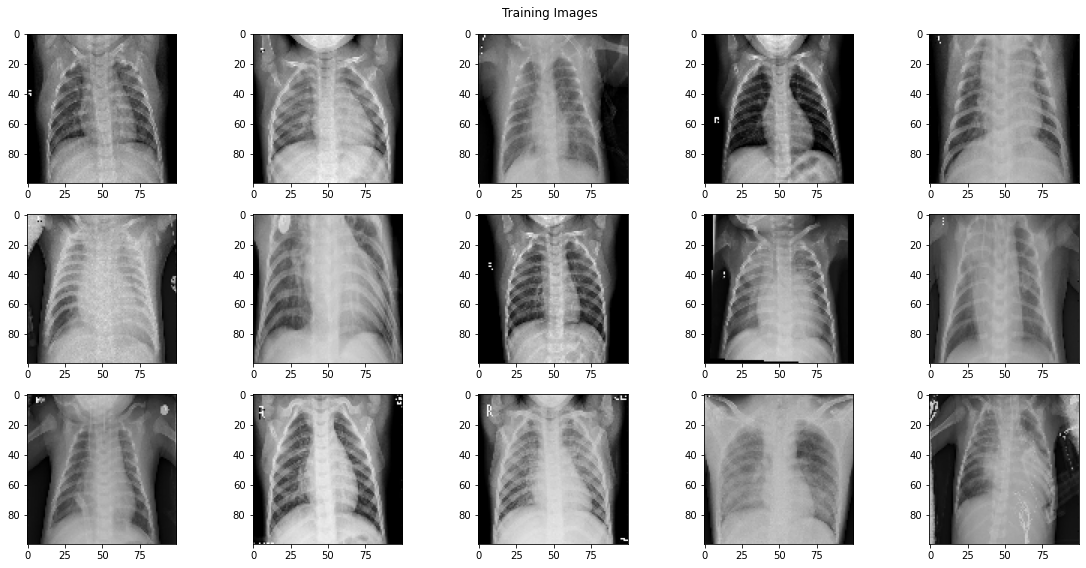

In [9]:
# Visualize
train_batch = train_data.next()
fig, axes = plt.subplots(3, 5, figsize=(16, 8))
    
for i in range(15):
    # Load image into numpy array and re-scale
    img = np.array(train_batch[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
fig.suptitle('Training Images')
plt.tight_layout()
plt.show()

### Baseline Model
Essentially a logistic regression model with a single node output layer using a sigmoid activation function and 1 epocs.

In [10]:
# Building baseline logistic regression model
model_0 = keras.Sequential(
    [   keras.Input(shape=(100,100,3)), 
        keras.layers.Flatten(), 
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 30001     
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile model
model_0.compile(loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [12]:
# Fit model
model_0.fit(train_data, epochs=1, batch_size=15, validation_data=(test_data))

349/349 [==============================] - 68s 194ms/step - loss: 1.4331 - recall: 0.8509 - val_loss: 2.2336 - val_recall: 0.9949


### Model 1
Added a 8 node hidden layer, continuing sigmoid activation function, rmsprop optimizer, and 3 epochs.

In [13]:
# Building baseline logistic regression model
model_1 = keras.Sequential(
    [   keras.Input(shape=(100,100,3)),
        keras.layers.Dense(8, activation="sigmoid"),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100, 100, 16)      64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 160001    
Total params: 160,065
Trainable params: 160,065
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile model
model_1.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [15]:
# Fit model
model_1.fit(train_data, epochs=3, batch_size=15, validation_data=(test_data))

Epoch 1/3
349/349 [==============================] - 72s 207ms/step - loss: 13.7797 - recall_1: 0.7409 - val_loss: 8.3984 - val_recall_1: 1.0000
Epoch 2/3
349/349 [==============================] - 70s 200ms/step - loss: 6.4242 - recall_1: 0.7914 - val_loss: 3.0262 - val_recall_1: 0.4359
Epoch 3/3
349/349 [==============================] - 68s 195ms/step - loss: 3.3307 - recall_1: 0.8591 - val_loss: 2.5173 - val_recall_1: 0.9872


### Model 2
Adding more layers with halfing numbers of nodes, switching to relu activation for the hidden layers, and adding Adam optimizer and 5 epoch  run for improved model performance

1st layer: 16 node hidden Conv2D layer, relu activation function<br/>
2nd layer: 8 node hidden Dense layer, relu activation function<br/>
3rd layer: Single node Dense layer, sigmoid activation function<br/>
Adam optimizer and 5 epochs

In [16]:
# Building baseline logistic regression model
model_2 = keras.Sequential(
    [   keras.Input(shape=(100,100,3)),
        keras.layers.Conv2D(16, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 294920    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 296,145
Trainable params: 296,145
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile model
model_2.compile(optimizer=keras.optimizers.Adam(lr=.003),
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [18]:
# Fit model
training_sample = train_data.n
model_2.fit(train_data, epochs=5, batch_size=15, 
            steps_per_epoch=int((training_sample//15)-1),
            validation_data=(test_data))

Epoch 1/5
347/347 [==============================] - 76s 219ms/step - loss: 0.6637 - recall_2: 0.9878 - val_loss: 0.6643 - val_recall_2: 1.0000
Epoch 2/5
347/347 [==============================] - 76s 219ms/step - loss: 0.5756 - recall_2: 1.0000 - val_loss: 0.6828 - val_recall_2: 1.0000
Epoch 3/5
347/347 [==============================] - 76s 218ms/step - loss: 0.5703 - recall_2: 1.0000 - val_loss: 0.6919 - val_recall_2: 1.0000
Epoch 4/5
347/347 [==============================] - 77s 222ms/step - loss: 0.5698 - recall_2: 1.0000 - val_loss: 0.6922 - val_recall_2: 1.0000
Epoch 5/5
347/347 [==============================] - 82s 236ms/step - loss: 0.5703 - recall_2: 1.0000 - val_loss: 0.6921 - val_recall_2: 1.0000


### Model 3
Adding more layers with halfing numbers of nodes, bumping up to 10 epoch run for improved model performance

1st layer: 64 node hidden Conv2D layer, relu activation function<br/>
2nd layer: 32 node hidden Conv2D layer, relu activation function<br/>
3d layer: 16 node hidden Dense layer, relu activation function<br/>
4th layer: Single node Dense layer, sigmoid activation function<br/>
Adam optimizer and 10 epochs

In [19]:
# Building baseline logistic regression model
model_3 = keras.Sequential(
    [   keras.Input(shape=(100,100,3)),
        keras.layers.Conv2D(64, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                247824    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
# Compile model
model_3.compile(optimizer=keras.optimizers.Adam(lr=.003),
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [21]:
# Fit model
model_3.fit(train_data, epochs=10, batch_size=15, 
                        steps_per_epoch=int((training_sample//15)-1),
                        validation_data=(test_data))

Epoch 1/10
347/347 [==============================] - 137s 395ms/step - loss: 0.6504 - recall_3: 0.9837 - val_loss: 0.6645 - val_recall_3: 1.0000
Epoch 2/10
347/347 [==============================] - 130s 376ms/step - loss: 0.5757 - recall_3: 1.0000 - val_loss: 0.6831 - val_recall_3: 1.0000
Epoch 3/10
347/347 [==============================] - 119s 343ms/step - loss: 0.5697 - recall_3: 1.0000 - val_loss: 0.6912 - val_recall_3: 1.0000
Epoch 4/10
347/347 [==============================] - 118s 340ms/step - loss: 0.5692 - recall_3: 1.0000 - val_loss: 0.6970 - val_recall_3: 1.0000
Epoch 5/10
347/347 [==============================] - 119s 343ms/step - loss: 0.5705 - recall_3: 1.0000 - val_loss: 0.6957 - val_recall_3: 1.0000
Epoch 6/10
347/347 [==============================] - 134s 387ms/step - loss: 0.5690 - recall_3: 1.0000 - val_loss: 0.6966 - val_recall_3: 1.0000
Epoch 7/10
347/347 [==============================] - 138s 397ms/step - loss: 0.5709 - recall_3: 1.0000 - val_loss: 0.6952 -

## Conclusions
Given recent events, including a global pandemic that frequently resulted in pneumonia for those affected and overwhelmed healthcare resources, having a diagnostic support tool to accelerate diagnosis without adding strain to hospital staff is of enormous value. Our diagnostic support tool accurately identifies pediatric pneumonia 100% of the time. We think our diagnostic support tool could be particularly valuable in underserviced communities around the world where pediatric radiologists are scarce.

## Future Considerations
With more time and data we believe our diagnostic support tool can be further improved and may be applicable for evaluation of adult chest xrays. We also plan to refine our model toaccurately differentiate between bacterial and viral pneumonia. Additionally, incorporation clinical data, such vitals signs and blood lab tests, shoulder further improve our diagnostic support tool.